## Chat Data Challenge

#### Import Libraries & Setup Engines

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sql
import plotly.express as px
import plotly.graph_objects as go

sql_engine = sql.create_engine('mssql+pyodbc://@localhost')

#### Read the CSV Files into SQL Server
My thinking here is that data may live a SQL database more often than a CSV, so this showcases both

In [2]:
t0 = 'CHAT_MESSAGES'
t1 = 'CHAT_USERS' 

csv0 = pd.read_csv(t0+'.csv')
csv1 = pd.read_csv(t1+'.csv')

sql_engine.execute(f'DROP TABLE IF EXISTS {t0}') 
sql_engine.execute(f'DROP TABLE IF EXISTS {t1}') 

csv0.to_sql(t0, sql_engine, index=False)
csv1.to_sql(t1, sql_engine, index=False)
print(f'{t0} & {t1} loaded') 

CHAT_MESSAGES & CHAT_USERS loaded


#### Grab the chat_messages table from SQL Server
I like to explicitly set dtypes here when appropriate, but for now let's just ensure pandas knows message_time is a datetime using parse_dates

In [3]:
query = f'SELECT * FROM {t0}'
m = pd.read_sql_query(query, sql_engine, parse_dates=['message_time']) 
print(f'Records: {m.shape[0]}') 
m.head(3)

Records: 500


,channel_id,user_id,message_time,message_id
0,eaacc5c5b477826600c5fff519c4d3cb,6613cf58d65e4bdaf099436f6d3d536d,2021-09-18 02:35:23+00:00,1
1,e9457f9288e1e36f0ab8636ebe6347e2,7709f636779832e319bd0696756238b7,2021-09-20 13:12:17+00:00,2
2,e9457f9288e1e36f0ab8636ebe6347e2,7709f636779832e319bd0696756238b7,2021-09-20 13:13:16+00:00,3


#### Grab the chat_users table
We could have joined the tables above, but .merge's validation argument is very useful, so I like to use that when our data fits in memory

In [4]:
query = f'SELECT * FROM {t1}'
u = pd.read_sql_query(query, sql_engine) 
print(f'Records: {u.shape[0]}') 
u.head(3)

Records: 40


,user_id,chat_role
0,6613cf58d65e4bdaf099436f6d3d536d,member
1,7709f636779832e319bd0696756238b7,coach
2,fcd00f6230686a991d73284c65059b96,member


#### Join the tables
We can ensure that the join cardinality is many-to-one by testing the uniqueness of the right join key, or by passing validate='m:1'. Let's do both.  We get the expected number of records, so that's good. 

In [5]:
stmt = '' if u['user_id'].is_unique else 'NOT '
print(f'user_id is {stmt}unique') 

df = m.merge(u, how='left', validate='m:1')
print(f'Records: {df.shape[0]}') 
df.head()

user_id is unique
Records: 500


,channel_id,user_id,message_time,message_id,chat_role
0,eaacc5c5b477826600c5fff519c4d3cb,6613cf58d65e4bdaf099436f6d3d536d,2021-09-18 02:35:23+00:00,1,member
1,e9457f9288e1e36f0ab8636ebe6347e2,7709f636779832e319bd0696756238b7,2021-09-20 13:12:17+00:00,2,coach
2,e9457f9288e1e36f0ab8636ebe6347e2,7709f636779832e319bd0696756238b7,2021-09-20 13:13:16+00:00,3,coach
3,708a314ed284c5748111998d10a583c9,fcd00f6230686a991d73284c65059b96,2021-09-20 16:20:21+00:00,4,member
4,708a314ed284c5748111998d10a583c9,fcd00f6230686a991d73284c65059b96,2021-09-20 16:21:23+00:00,5,member


#### Check assumptions

In [6]:
max_users = df[['channel_id', 'user_id']].groupby('channel_id').nunique().max()[0]
print(f'A channel has a maximum of {max_users} users.')

A channel has a maximum of 2 users.


#### Split the tables

In [7]:
members = df[df['chat_role']=='member'].copy()
coaches = df[df['chat_role']=='coach'].copy()
print(f'There are {members.shape[0]} member messages, and {coaches.shape[0]} responses from coaches.')

There are 244 member messages, and 256 responses from coaches.


Now we can start answering some questions! 

### Part 1: 

#### What is the average and median time between a ‘member’ sending a message and a coach responding to that message?

In [8]:
# Let's join all of the member messages with the messages from their coaches
msgs = members[['channel_id', 'message_time', 'message_id']]\
.merge(coaches[['channel_id', 'message_time']], how='left', on='channel_id', suffixes=['_mbr', '_coach'])

# We only want coach messages that occur after member messages
msgs = msgs[msgs['message_time_coach'] > msgs['message_time_mbr']]

# We want the earliest message from the coach for each member message, so sort and drop duplicates
msgs.sort_values('message_time_coach', inplace=True)
msgs.drop_duplicates(subset=['message_id'], inplace=True) 

msgs.loc[:,'lag'] = msgs['message_time_coach'] - msgs['message_time_mbr']

print(f'{len(members)-len(msgs)} messages did not get a response yet\n')
print(f"Average Lag: {msgs['lag'].mean()}")
print(f"Median Lag: {msgs['lag'].median()}\n")
print(f"Min Lag: {msgs['lag'].min()}")
print(f"Max Lag: {msgs['lag'].max()}\n")
print(f"Lag STDev: {msgs['lag'].std()}\n")

msgs.head()

9 messages did not get a response yet

Average Lag: 0 days 14:40:21.974468085
Median Lag: 0 days 01:20:55

Min Lag: 0 days 00:00:01
Max Lag: 17 days 22:30:59

Lag STDev: 1 days 23:52:13.115784416



,channel_id,message_time_mbr,message_id,message_time_coach,lag
0,eaacc5c5b477826600c5fff519c4d3cb,2021-09-18 02:35:23+00:00,1,2021-09-20 18:09:54+00:00,2 days 15:34:31
29,8e2c979f620ff43e7ce076ee142f3c10,2021-09-20 19:03:30+00:00,10,2021-09-20 20:24:10+00:00,0 days 01:20:40
26,8e2c979f620ff43e7ce076ee142f3c10,2021-09-20 19:03:15+00:00,9,2021-09-20 20:24:10+00:00,0 days 01:20:55
6,708a314ed284c5748111998d10a583c9,2021-09-20 16:20:21+00:00,4,2021-09-20 20:24:37+00:00,0 days 04:04:16
16,708a314ed284c5748111998d10a583c9,2021-09-20 16:21:23+00:00,5,2021-09-20 20:24:37+00:00,0 days 04:03:14


### Part 2: 

#### If choosing between average and median response time, which do you think best captures how quickly messages are being responded to? 
When histograms and box plots are available, there's no reason to limit ourselves to mean and median.. but to answer the question, I would lean toward the average because outliers may turn out to be rather important in this context, where an extra long wait time might have a non-linear impact. For example, if someone is experiencing a mental health event, a ten hour delay might be more than ten times worse than a one hour delay. On the other hand, if outliers are routinely innocuous, then the mean could be a better representation. 

#### What are some limitations with both approaches? 
With a mean, you're going to be impacted more by wild outliers. If you are mainly interested in where the bulk of activity is happening, a median (or box plot) might be a better choice.  When it comes to medians, the opposite effect can occur, and you can lose out on activity that is happening on the tail ends of your distribution. Given this, I think it is crucial to look at a battery of metrics, and weigh their importance based on the context of your analysis. 

#### What are some other metrics that one might consider for response times?
Non-response is definitely important. We'd want to check on those 9 messages that haven't received a response yet and make sure they are somewhat recent.  It would be a good idea to look at the min and max, probably max being more important in this context.  I'd also like to see how lag varies on average, using standard deviation. We also might want to take a look at how lag varies across coaches. 

#### Histogram & Box Plot
These are better as interactive plots with zoom enabled, but I'm not sure how greenhouse handles rendering, so I'm making them static to be safe.  

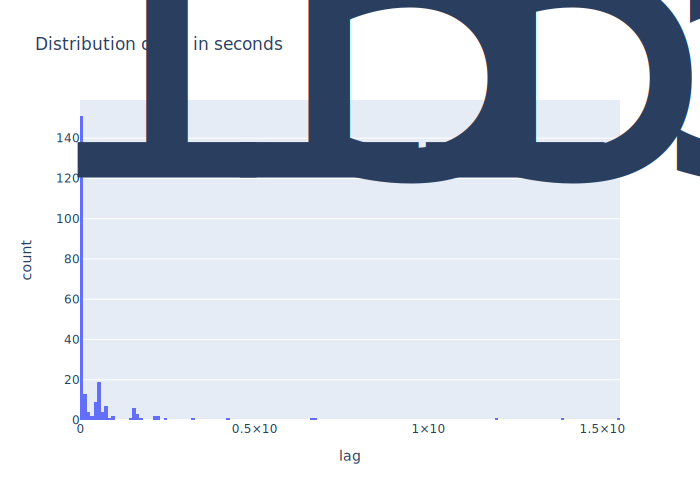

In [9]:
hist = px.histogram(msgs, x='lag', nbins=300, title='Distribution of lag in seconds')
hist.show('svg')

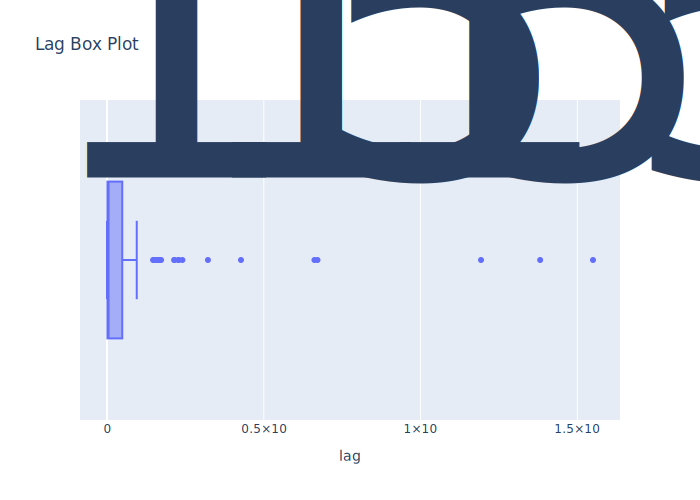

In [10]:
box = px.box(msgs, x='lag', title='Lag Box Plot')
box.show('svg')

### Part 3: 

#### Create some plots and/or tables to show how message volume for each role varies by day of week and time of day.
#### Are there patterns to when members and coaches send messages by day of week or time of day? 

In [11]:
vol = df[['message_time', 'chat_role']].copy()

vol.loc[:,'day'] = vol['message_time'].dt.day_name()
vol.loc[:,'hour'] = vol['message_time'].dt.hour

vol.head(3)

,message_time,chat_role,day,hour
0,2021-09-18 02:35:23+00:00,member,Saturday,2
1,2021-09-20 13:12:17+00:00,coach,Monday,13
2,2021-09-20 13:13:16+00:00,coach,Monday,13


#### Day of Week

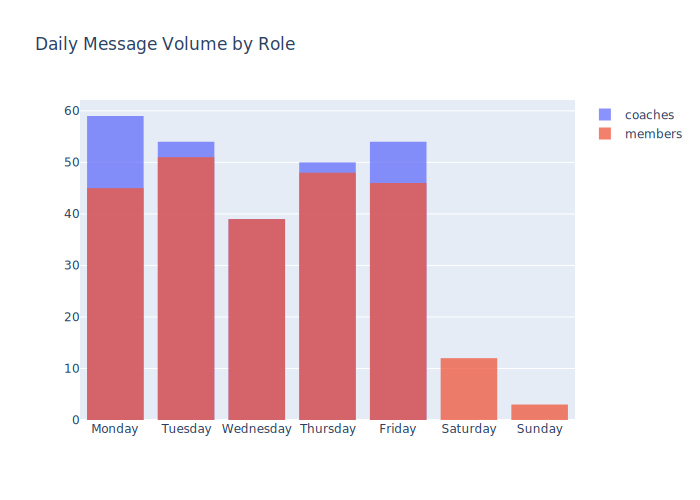

In [12]:
day = go.Figure()
day.add_trace(go.Histogram(x=vol[vol['chat_role']=='coach']['day'], name='coaches'))
day.add_trace(go.Histogram(x=vol[vol['chat_role']=='member']['day'], name='members'))

day.update_layout(title='Daily Message Volume by Role', barmode='overlay')
day.update_traces(opacity=0.75)
day.show('svg')

It appears there is a bi-modal distribution of volume by day of week, with peaks around the beginning and end of the work week. Coaches do not seem to respond during the weekend. 

#### Time of Day

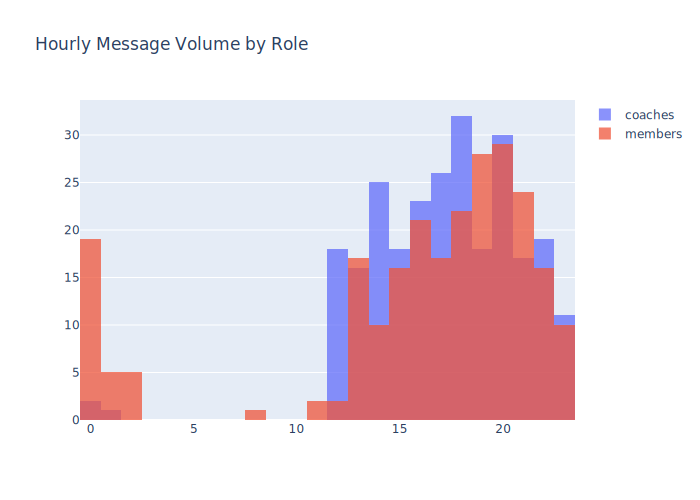

In [13]:
tod = go.Figure()
tod.add_trace(go.Histogram(x=vol[vol['chat_role']=='coach']['hour'], nbinsx=24, name='coaches'))
tod.add_trace(go.Histogram(x=vol[vol['chat_role']=='member']['hour'], nbinsx=24, name='members'))

tod.update_layout(title='Hourly Message Volume by Role', barmode='overlay')
tod.update_traces(opacity=0.75)
tod.show('svg')

There is a peak for both members and coaches during the evening, with very little activity during early, pre-work hours. 

An interesting, counter-intuitive callout is that the coach distribution is centered a little earlier than for the members. 

***

#### Appendix: Investigate unanswered messages

In [14]:
x = members.merge(coaches, how='left', on='channel_id', suffixes=['_mbr', '_coach'])
x = x[~x['message_id_mbr'].isin(msgs['message_id'])]
print(f"The following messages have not been responded to: {list(x['message_id_mbr'].unique())}\n")

The following messages have not been responded to: [338, 357, 401, 410, 453, 458, 487, 498, 500]



In [15]:
def get_details(msg): 
    xi = x[x['message_id_mbr']==msg]
    return xi

In [16]:
get_details(338) 

,channel_id,user_id_mbr,message_time_mbr,message_id_mbr,chat_role_mbr,user_id_coach,message_time_coach,message_id_coach,chat_role_coach
1653,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-09-23 17:46:59+00:00,73,coach
1654,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-09-28 16:44:43+00:00,146,coach
1655,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-09-28 22:19:36+00:00,154,coach
1656,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-10-01 18:48:47+00:00,196,coach
1657,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-10-01 20:42:07+00:00,202,coach
1658,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-10-04 17:38:14+00:00,223,coach
1659,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-10-08 18:11:48+00:00,329,coach
1660,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-10-08 18:19:39+00:00,330,coach
1661,6affa2ce2e0eb068fda023dc469d950f,3a6421e737374430873c120ded6e9e5c,2021-10-09 21:54:21+00:00,338,member,5124e374e147342fc9cad88a5a5eec7c,2021-10-08 22:55:06+00:00,333,coach


In [17]:
get_details(410) 

,channel_id,user_id_mbr,message_time_mbr,message_id_mbr,chat_role_mbr,user_id_coach,message_time_coach,message_id_coach,chat_role_coach
1975,acb41fdc979596ce8af492cba0f9431b,1c19811d6ff3419fe916a0c1265db1a1,2021-10-13 18:09:58+00:00,410,member,8716fac2c87a3cc6d0c998958948133e,2021-10-11 15:41:05+00:00,345,coach
1976,acb41fdc979596ce8af492cba0f9431b,1c19811d6ff3419fe916a0c1265db1a1,2021-10-13 18:09:58+00:00,410,member,8716fac2c87a3cc6d0c998958948133e,2021-10-12 17:11:50+00:00,392,coach
1977,acb41fdc979596ce8af492cba0f9431b,1c19811d6ff3419fe916a0c1265db1a1,2021-10-13 18:09:58+00:00,410,member,8716fac2c87a3cc6d0c998958948133e,2021-10-12 17:49:03+00:00,395,coach
1978,acb41fdc979596ce8af492cba0f9431b,1c19811d6ff3419fe916a0c1265db1a1,2021-10-13 18:09:58+00:00,410,member,8716fac2c87a3cc6d0c998958948133e,2021-10-13 18:04:29+00:00,409,coach


In [18]:
get_details(500)

,channel_id,user_id_mbr,message_time_mbr,message_id_mbr,chat_role_mbr,user_id_coach,message_time_coach,message_id_coach,chat_role_coach
2323,1b3450a69c3bc7c06a82c40e4ad3e43a,78d3d7b88eb66eec415e03de403002c2,2021-10-18 17:36:59+00:00,500,member,8716fac2c87a3cc6d0c998958948133e,2021-10-14 18:09:34+00:00,439,coach


Some of these are pretty old. It may be a good idea to look at the semantic context of these final messages. Just because the member was the last one to send a message does not indicate a negative experience. For example, a conversation naturally ending with the member saying "Thanks for all your help!" or "ok, talk more later" could very well be a positive experience. 

***

Luke Simmons - 2022